# preparing and understanding the data

here we will pass the data by a several  process to prepare it before start the training process


lets start by importing the DataGen that contains some useful functions to work the data 

In [22]:
import DataGen
from os import listdir
from os.path import isfile, join 
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd

%matplotlib inline
%load_ext autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
DataGen.decompress_dataset()

data already decompressed


now lets create a list with the files from the test set 

In [24]:

files = []
for name in ['a', 'b', 'c', 'd', 'e']:
    path = "./decompressed_dataset/"+name+"_test/jpg"
    files = files + [join(path, f) for f in listdir(path) if isfile(join(path, f))]


lets choose an image at random to test our process

In [25]:

image_path = random.choice(files)


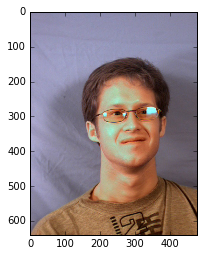

In [26]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

lets check the landmarks positions for that we nee to get the labels loaded

In [27]:
labels = DataGen.load_labels()
image_name = image_path.split("/")[-1].split(".")[0]
label = labels.loc[labels['name'] == image_name].values.tolist()[0][2:]

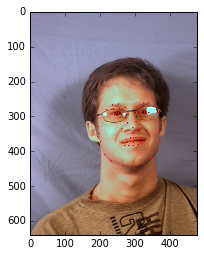

In [28]:
for i in range(0,151,2):
    cv2.circle(image, (int(label[i]),int(label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(image)

now lets crop the image and see the result

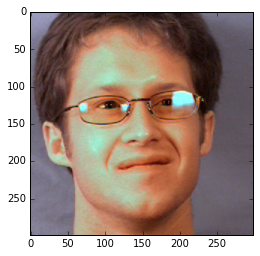

In [29]:
%autoreload
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
croped_image, box = DataGen.crop_image(image2, 299)
croped_label = DataGen.replace_landmarks(box, label) 
plt.imshow(croped_image)


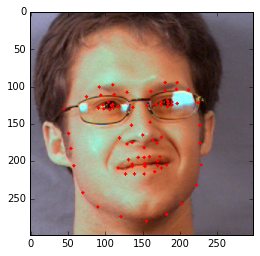

In [30]:
copy_of_croped_image = croped_image
for i in range(0,151,2):
    cv2.circle(copy_of_croped_image, (int(croped_label[i]),int(croped_label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(copy_of_croped_image)

now lets test the flipping of a image

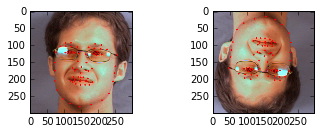

In [31]:
hflip = DataGen.flip_image(croped_image, croped_label, 1, 299, 299)
vflip = DataGen.flip_image(croped_image, croped_label, 0, 299, 299)
for i in range(0,151,2):
    cv2.circle(hflip[0], (int(hflip[1][i]),int(hflip[1][i+1]) ), 2, (255, 0, 0), -1)
    cv2.circle(vflip[0], (int(vflip[1][i]),int(vflip[1][i+1]) ), 2, (255, 0, 0), -1)


fig = plt.figure()
plt.subplot(221)
plt.imshow(hflip[0])
plt.subplot(222)
plt.imshow(vflip[0])
plt.show()

time to process the all images and create the data set

In [ ]:
%autoreload
dataset = DataGen.create_dataset(299, flip_horizontal=True, flip_vertical=True)
print("total of train images = "+str(len(dataset["train_set"])))
print("total of test images = "+str(len(dataset["test_set"])))
DataGen.save_dataset(dataset, "299_dataset.npz")

100% (100.0 of 100) |#####################| Elapsed Time: 0:03:28 ETA:  0:00:008:23:2647

total of train images = 7515
total of test images = 3735


In [ ]:
%autoreload
dataset = np.load("299_dataset.npz")
DataGen.inception_bottleneck(dataset["train_x"], "inception_train.npy")
DataGen.inception_bottleneck(dataset["test_x"], "inception_test.npy")

In [9]:
train_norm = train_labels/299
test_norm = test_labels/299

NameError: name 'train_labels' is not defined

In [77]:
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint 

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

checkpointer = ModelCheckpoint(filepath='best.inception.hdf5', 
                               verbose=1, save_best_only=True)

model = Sequential()
model.add(Dense(1000,input_shape=train_set.shape[1:],kernel_initializer='uniform'))
model.add(Dense(1024,kernel_initializer='uniform'))
model.add(Dense(512,kernel_initializer='uniform'))
model.add(Dense(152,kernel_initializer='uniform'))
model.add(Dense(152,kernel_initializer='uniform', activation='linear'))



model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1025024   
_________________________________________________________________
dense_29 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_30 (Dense)             (None, 152)               77976     
_________________________________________________________________
dense_31 (Dense)             (None, 152)               23256     
Total params: 2,652,056
Trainable params: 2,652,056
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
model.fit(train_set, train_norm, validation_data=(test_set,test_norm), callbacks=[checkpointer,tbCallBack], epochs=100, batch_size=100, verbose=1, shuffle=True)

Train on 7500 samples, validate on 1231 samples
Epoch 1/100
7500/7500 [==============================] - 5s - loss: 0.0527 - acc: 0.1383 - val_loss: 0.0260 - val_acc: 0.1974
Epoch 2/100
7500/7500 [==============================] - 4s - loss: 0.0359 - acc: 0.2015 - val_loss: 0.0254 - val_acc: 0.1763
Epoch 3/100
7500/7500 [==============================] - 4s - loss: 0.0358 - acc: 0.2096 - val_loss: 0.0259 - val_acc: 0.4492
Epoch 4/100
7500/7500 [==============================] - 3s - loss: 0.0359 - acc: 0.2099 - val_loss: 0.0265 - val_acc: 0.6141
Epoch 5/100
7500/7500 [==============================] - 3s - loss: 0.0361 - acc: 0.2571 - val_loss: 0.0272 - val_acc: 0.2266
Epoch 6/100
7500/7500 [==============================] - 3s - loss: 0.0361 - acc: 0.2289 - val_loss: 0.0269 - val_acc: 0.6450
Epoch 7/100
7500/7500 [==============================] - 3s - loss: 0.0360 - acc: 0.2693 - val_loss: 0.0294 - val_acc: 0.1064
Epoch 8/100
7500/7500 [==============================] - 3s - loss: 0.

7500/7500 [==============================] - 4s - loss: 0.0358 - acc: 0.3939 - val_loss: 0.0256 - val_acc: 0.1080
Epoch 33/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.4164 - val_loss: 0.0263 - val_acc: 0.6426
Epoch 34/100
7500/7500 [==============================] - 3s - loss: 0.0357 - acc: 0.4092 - val_loss: 0.0259 - val_acc: 0.6198
Epoch 35/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.4196 - val_loss: 0.0251 - val_acc: 0.6320
Epoch 36/100
7500/7500 [==============================] - 3s - loss: 0.0357 - acc: 0.4175 - val_loss: 0.0263 - val_acc: 0.6182
Epoch 37/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.4315 - val_loss: 0.0274 - val_acc: 0.6312
Epoch 38/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.4136 - val_loss: 0.0255 - val_acc: 0.6288
Epoch 39/100
7500/7500 [==============================] - 3s - loss: 0.0358 - acc: 0.3604 - val_loss: 0.0265 - val_acc: 0.62

7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.3995 - val_loss: 0.0270 - val_acc: 0.6255
Epoch 98/100
7500/7500 [==============================] - 4s - loss: 0.0356 - acc: 0.4096 - val_loss: 0.0251 - val_acc: 0.6344
Epoch 99/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.4163 - val_loss: 0.0271 - val_acc: 0.2210
Epoch 100/100
7500/7500 [==============================] - 3s - loss: 0.0356 - acc: 0.3861 - val_loss: 0.0255 - val_acc: 0.6296


In [79]:
model.load_weights("best.inception.hdf5")  

In [80]:
from keras.applications.inception_v3 import InceptionV3

In [81]:
incep = InceptionV3(weights='imagenet')

[[ 0.36826074  0.45119062  0.37117353  0.49712968  0.37400836  0.5204559
   0.37957844  0.56530404  0.39302683  0.59969574  0.42409444  0.61936092
   0.46748453  0.63587809  0.50683737  0.63944036  0.54403919  0.62953484
   0.57934678  0.61599052  0.60491091  0.59482127  0.62011981  0.56538969
   0.6264286   0.5256635   0.63012141  0.49900794  0.62681133  0.45707157
   0.56117129  0.39026797  0.58844119  0.41275805  0.55842704  0.41447002
   0.53128099  0.42735025  0.56174815  0.42933124  0.58766639  0.42530331
   0.38976783  0.42759025  0.4136745   0.4157328   0.44761035  0.41325486
   0.48342544  0.42644837  0.44647098  0.42695069  0.41519704  0.42382801
   0.41174018  0.45154446  0.43844616  0.44209731  0.46697104  0.4556686
   0.44152981  0.46129462  0.4396826   0.44970042  0.59255785  0.45413437
   0.56773907  0.44543701  0.54079401  0.45488364  0.56801695  0.46204162
   0.56504333  0.45215586  0.49466035  0.4535259   0.48970765  0.49056858
   0.46801952  0.50600314  0.47745278  0

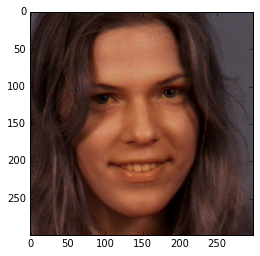

In [82]:
from keras.preprocessing import image 

image = cv2.imread("./decompressed_dataset/a_test/jpg/i000qa-fn.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ima = create_sets.crop_picture(image, 299)
plt.imshow(ima[0])

img = np.array([ima[0]])
btl = incep.predict(img)
pred = model.predict(btl)
print(pred)
pred_vals = pred*299
print(pred_vals)

In [83]:

for i in range(0,151,2):
    cv2.circle(ima[0], (int(pred_vals[0][i]),int(pred_vals[0][i+1]) ), 2, (255, 0, 0), -1)

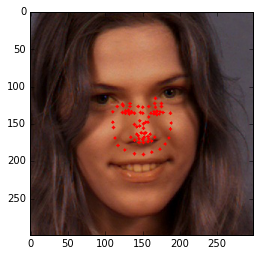

In [84]:
plt.imshow(ima[0])